# Factors dataset construction

This notebook constructs the dataset of monthly returns for the five target equity factors: Growth, Value, Momentum, Low Volatility, and Quality.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from functools import reduce

## Quality Factor 

The "Quality" factor is sourced from AQR Capital Management. Since this data comes in an Excel format with specific headers, we need to load the specific sheet, clean the column names and ensure the dates are in a datetime object format for future merging.

In [2]:
aqr_qmj = pd.read_excel(
    "Quality Minus Junk Factors Monthly.xlsx",
    sheet_name="QMJ Factors",    
    skiprows=18                   
)

In [3]:
aqr_qmj.columns = aqr_qmj.columns.str.lower().str.strip()
aqr_qmj = aqr_qmj.rename(columns={"date": "date", "usa": "quality"})
aqr_qmj = aqr_qmj[pd.to_datetime(aqr_qmj["date"], errors="coerce").notnull()]
aqr_qmj["date"] = pd.to_datetime(aqr_qmj["date"])
aqr_qmj = aqr_qmj.sort_values("date")
aqr_qmj = aqr_qmj[["date", "quality"]]

In [ ]:
aqr_qmj

,date,quality
0,1957-07-31,0.011154
1,1957-08-31,0.004877
2,1957-09-30,0.007009
3,1957-10-31,0.002708
4,1957-11-30,-0.008971
...,...,...
814,2025-05-31,-0.017397
815,2025-06-30,-0.042200
816,2025-07-31,-0.011030
817,2025-08-31,-0.008783


## Other factors 

This section processes the remaining four factors: Growth, Value, Momentum, and Low Volatility. Unlike the AQR data, these are sourced from Bloomberg ans so they are cvs files containing raw Index Prices rather than pre-calculated returns. We define a helper function load_and_process to read the files, locate the "Last Price" column and calculate the monthly percentage change (pct_change) to derive the actual factor returns.

In [5]:
file_paths = {
    "growth": "SPTRSGX Index(growth).csv",
    "value": "SPTRSVX Index(value).csv",
    "momentum": "SP500MUP(momentum).csv",
    "low_vol": "SP5LVIT Index(low_vol).csv"
}

In [6]:
def to_month_end(df):
    df["date"] = pd.to_datetime(df["date"])
    df["date"] = df["date"] + pd.offsets.MonthEnd(0)
    return df

In [7]:
def load_and_process(path):
    df = pd.read_csv(path)
    
    df.columns = df.columns.str.lower().str.strip()
    
    price_col = None
    for col in df.columns:
        if "last price" in col:
            price_col = col
            break
    
    if price_col is None:
        raise ValueError(f"No price column found in {path}")
    
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values("date")
    
    df["ret"] = df[price_col].pct_change()
    
    return df[["date", "ret"]]

## Construction of final dataset

This section integrates the independent dataframes into a single master dataset. A critical step here is Date Alignment. We force all dates to the "Month End" to ensure the merge logic works correctly. We use functools.reduce to merge the S&P factors first, then merge in the AQR Quality factor and finally drop any rows with missing data to ensure a clean timeline.

In [8]:
factors = []

for fac, path in file_paths.items():
    temp = load_and_process(path)
    temp = temp.rename(columns={"ret": fac})
    factors.append(temp)

In [9]:
factors_df_new = reduce(lambda left, right: pd.merge(left, right, on="date", how="outer"), factors)
factors_df_new = to_month_end(factors_df_new)
factors_df_new = pd.merge(
    factors_df_new,
    aqr_qmj,
    on="date",
    how="left"
)
factors_df_new = factors_df_new.dropna().reset_index(drop=True)

In [10]:
factors_df_new.to_csv("df_factors.csv", index=False)

In [11]:
factors_df_new = factors_df_new.sort_values("date").reset_index(drop=True)
factor_cols = ['growth', 'value', 'quality', 'momentum', 'low_vol']
cumret_df = (1 + factors_df_new[factor_cols]).cumprod()
cumret_df['date'] = factors_df_new['date']

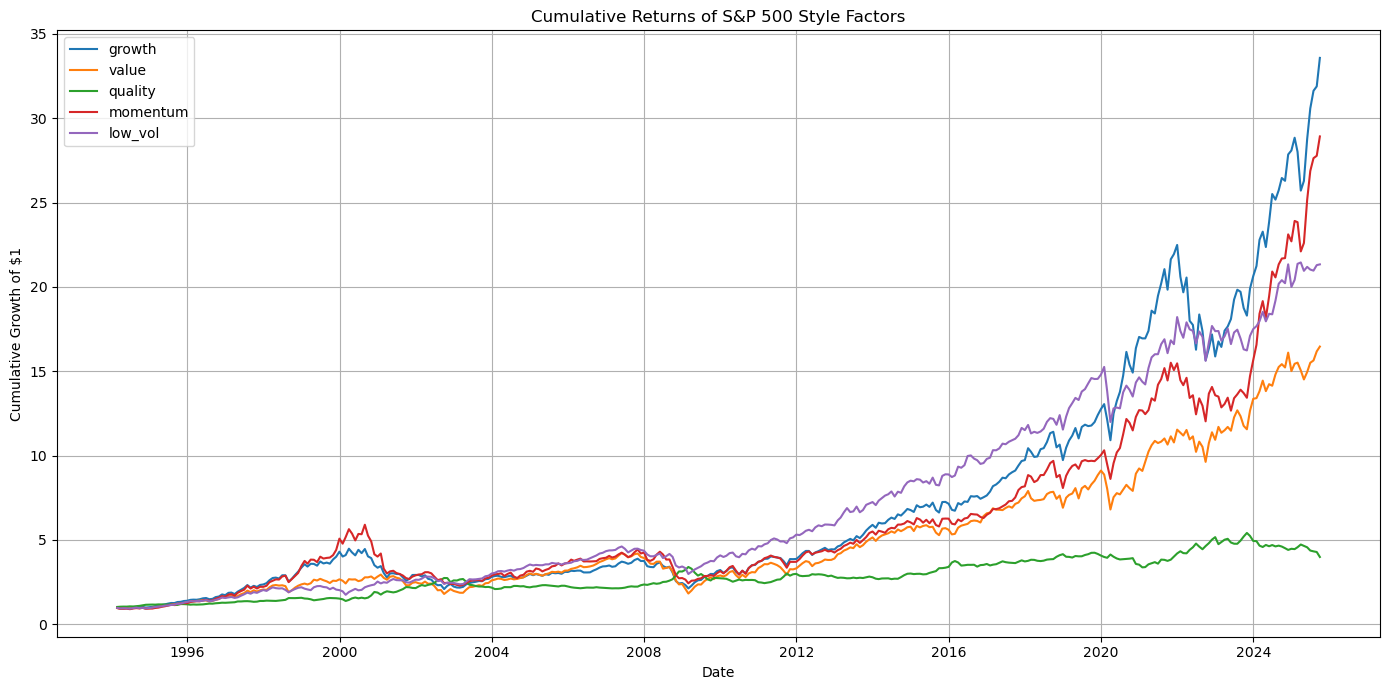

In [12]:
plt.figure(figsize=(14, 7))

for fac in factor_cols:
    plt.plot(cumret_df['date'], cumret_df[fac], label=fac)

plt.title("Cumulative Returns of S&P 500 Style Factors")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()